# LSTM
---

In [5]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_nico.nico_preprocessing import load_data, merge_oil, merge_ex_rate, get_oil_euro
from functions_nico.nico_models import baseline_model, print_model, split_data

In [6]:
# Load data
df = load_data("../data/fueldata/wertheim_23-25.parquet") # Load fuel data
df = merge_oil(df)                                        # Include oil data
df = merge_ex_rate(df)                                    # Include exchange rates
get_oil_euro(df)                                          # Calculate oil price in euro

# Reduce data
df = df[df["datetime"] >= pd.to_datetime("2025-04-01")]
df = df[df["station_uuid"] == "24e5e31e-b5fd-4c1a-96aa-84de7027ee94"]



In [8]:
# Feature creation
df["hour"] = df.datetime.dt.hour
df["dayofweek"] = df.datetime.dt.dayofweek

# Cyclic coding
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

features = ["datetime","e5", "hour_sin", "hour_cos", "dow_sin", "dow_cos"]
df_analysis = df[features]

# Prepare data
df_analysis = df_analysis.set_index("datetime")

# Scaling is needed for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_analysis)

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LEN = 12*24  # equals 1 day
X, y = create_sequences(scaled_data, SEQ_LEN)

In [9]:
model = Sequential()
model.add(LSTM(64, input_shape=(SEQ_LEN, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

model.fit(X, y, epochs=5, batch_size=64)

Epoch 1/5
242/242 [==============================] - 26s 105ms/step - loss: 0.2833
Epoch 2/5
242/242 [==============================] - 25s 104ms/step - loss: 0.2750
Epoch 3/5
242/242 [==============================] - 25s 105ms/step - loss: 0.2715
Epoch 4/5
242/242 [==============================] - 26s 105ms/step - loss: 0.2702
Epoch 5/5
242/242 [==============================] - 25s 105ms/step - loss: 0.2691


In [22]:
# Predictions
predictions = []
seq = scaled_data[-SEQ_LEN:].tolist()

for _ in range(SEQ_LEN):
    x_input = np.array(seq[-SEQ_LEN:]).reshape(1, SEQ_LEN, X.shape[2])
    pred = model.predict(x_input, verbose=0)

    next_time = df_analysis.index[-1] + pd.Timedelta(minutes=5 * (_ + 1))
    hour = next_time.hour
    dow = next_time.dayofweek

    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    dow_sin = np.sin(2 * np.pi * dow / 7)
    dow_cos = np.cos(2 * np.pi * dow / 7)
    seq.append([pred[0][0], hour_sin, hour_cos, dow_sin, dow_cos])
    predictions.append([pred[0][0], hour_sin, hour_cos, dow_sin, dow_cos])

pred_price = scaler.inverse_transform(np.array(predictions))[:,0]

In [24]:
df_pred = pd.concat([pd.DataFrame(df_analysis[-SEQ_LEN:].index),pd.DataFrame(pred_price,columns=["e5"])],axis=1,ignore_index=True)
df_pred.columns = ["datetime","e5"]

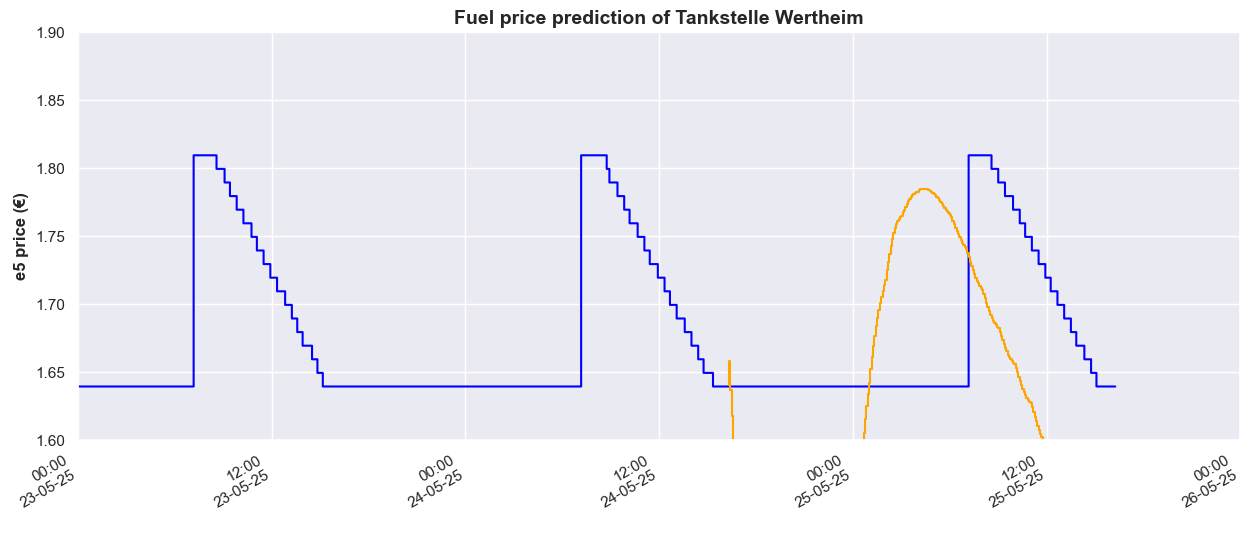

RMSE: 0.136
MAE: 0.129


In [25]:
# Print model results
print_model(df,df_pred,xlim=("2025-05-23","2025-05-26"),ylim=(1.6,1.9))

In [29]:
df_pred

,datetime,e5
0,2025-05-24 16:20:00,1.657985
1,2025-05-24 16:25:00,1.636459
2,2025-05-24 16:30:00,1.617517
3,2025-05-24 16:35:00,1.598812
4,2025-05-24 16:40:00,1.581289
...,...,...
283,2025-05-25 15:55:00,1.563481
284,2025-05-25 16:00:00,1.565349
285,2025-05-25 16:05:00,1.567105
286,2025-05-25 16:10:00,1.569562


In [34]:
pred_price

array([1.65798509, 1.63645882, 1.61751686, 1.59881152, 1.58128916,
       1.56530695, 1.55090471, 1.53796038, 1.52628871, 1.51526439,
       1.50542183, 1.49621229, 1.4875715 , 1.47948061, 1.47194773,
       1.4649984 , 1.45866312, 1.45296706, 1.44792245, 1.44352425,
       1.43975041, 1.43750507, 1.43582074, 1.43454818, 1.43356048,
       1.43280722, 1.4322425 , 1.43182916, 1.43153685, 1.43134064,
       1.43122007, 1.43115848, 1.43114206, 1.43275577, 1.43407461,
       1.43534368, 1.43642417, 1.43732618, 1.43806139, 1.43864769,
       1.43910439, 1.43945043, 1.43970363, 1.43988021, 1.43999449,
       1.44166281, 1.44288448, 1.44408403, 1.44509825, 1.44593935,
       1.44662028, 1.44715861, 1.44757315, 1.44788197, 1.44810219,
       1.44824932, 1.44833717, 1.44983502, 1.45094055, 1.45212269,
       1.45320228, 1.45417224, 1.4550308 , 1.45578299, 1.45643673,
       1.45700133, 1.45748667, 1.45790246, 1.45825796, 1.45990389,
       1.46128404, 1.46283941, 1.46439403, 1.46591379, 1.46737

In [33]:
df_analysis

,e5,hour_sin,hour_cos,dow_sin,dow_cos
datetime,,,,,
2025-04-01 00:00:00,1.689,0.000000,1.000000,0.781831,0.62349
2025-04-01 00:05:00,1.689,0.000000,1.000000,0.781831,0.62349
2025-04-01 00:10:00,1.689,0.000000,1.000000,0.781831,0.62349
2025-04-01 00:15:00,1.689,0.000000,1.000000,0.781831,0.62349
2025-04-01 00:20:00,1.689,0.000000,1.000000,0.781831,0.62349
...,...,...,...,...,...
2025-05-25 15:55:00,1.639,-0.707107,-0.707107,-0.781831,0.62349
2025-05-25 16:00:00,1.639,-0.866025,-0.500000,-0.781831,0.62349
2025-05-25 16:05:00,1.639,-0.866025,-0.500000,-0.781831,0.62349
